In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from keras.src.callbacks import EarlyStopping
import random
import numpy as np
import tensorflow as tf
from keras.api.layers import Dense, Dropout
from keras.api.models import Sequential
from keras.api.regularizers import l1, l2
from keras.api.optimizers import Adam

In [244]:
ptc = 0.000059

In [245]:
symbol = "EURUSD=X"
start = "2004-01-01"
end = "2024-08-22"
interval = '1d'

df = yf.download(symbol, start, end, interval=interval)
#df.rename(columns={"Close": "price"}, inplace=True)
df.drop(columns=['Adj Close', 'Volume'], inplace=True)
#df.index = df.index.tz_convert('utc')
df['returns'] = np.log(df['Close'].div(df['Close'].shift(1)))
df['day_of_week'] = df.index.dayofweek
df['dir'] = np.where(df['returns'] > 0, 1,0)
df.dropna(inplace=True)

tnx_symbol = "^TNX"

tnx = yf.download(tnx_symbol, start, end, interval=interval)
#df.rename(columns={"Close": "price"}, inplace=True)
tnx.drop(columns=['Adj Close', 'Open', 'High', 'Low'], inplace=True)
#df.index = df.index.tz_convert('utc')
tnx.rename(columns={'Close': 'tnx_close', 'Volume': 'tnx_volume'}, inplace=True)
tnx['tnx_returns'] = np.log(tnx['tnx_close'].div(tnx['tnx_close'].shift(1)))
#tnx['tnx_simple_returns'] = tnx['tnx_close'] - tnx['tnx_close'].shift(1)
tnx.dropna(inplace=True)
forex_combined = tnx.join(df, how='outer')

snp_symbol = "^SPX"

snp = yf.download(snp_symbol, start, end, interval=interval)
#df.rename(columns={"Close": "price"}, inplace=True)
snp.drop(columns=['Adj Close', 'Open', 'High', 'Low'], inplace=True)
#df.index = df.index.tz_convert('utc')
snp.rename(columns={'Close': 'snp_close', 'Volume': 'snp_volume'}, inplace=True)
snp['snp_returns'] = np.log(snp['snp_close'].div(snp['snp_close'].shift(1)))
snp.dropna(inplace=True)
forex_combined = snp.join(forex_combined, how='outer')

gold_symbol = "GC=F"

gold = yf.download(gold_symbol, start, end, interval=interval)
#df.rename(columns={"Close": "price"}, inplace=True)
gold.drop(columns=['Adj Close', 'Open', 'High', 'Low'], inplace=True)
#df.index = df.index.tz_convert('utc')
gold.rename(columns={'Close': 'gold_close', 'Volume': 'gold_volume'}, inplace=True)
gold['gold_returns'] = np.log(gold['gold_close'].div(gold['gold_close'].shift(1)))
gold.dropna(inplace=True)
forex_combined = gold.join(forex_combined, how='outer')

oil_symbol = "CL=F"

oil = yf.download(oil_symbol, start, end, interval=interval)
#df.rename(columns={"Close": "price"}, inplace=True)
oil.drop(columns=['Adj Close', 'Open', 'High', 'Low'], inplace=True)
oil.rename(columns={'Close': 'oil_close', 'Volume': 'oil_volume'}, inplace=True)
oil['oil_returns'] = np.log(oil['oil_close'].div(oil['oil_close'].shift(1)))
oil.dropna(inplace=True)
forex_combined = oil.join(forex_combined, how='outer')

import seaborn as sns
%matplotlib inline

forex_clean = forex_combined.copy()
forex_clean.drop(columns=['Open', 'High', 'Low'], inplace=True)

features = ['Close', 'returns', 'oil_returns', 'snp_returns', 'tnx_returns', 'gold_returns', 'gold_volume', 'snp_volume', 'tnx_volume',]
cols = []
for f in features:
    for lag in range(1, 7 + 1):
        col = "{}_lag_{}".format(f, lag)
        forex_clean[col] = forex_clean[f].shift(lag)
        cols.append(col)
forex_clean.dropna(inplace=True)

df = forex_clean.copy()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [246]:
def set_seeds(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
def cw(df):
    c0, c1 = np.bincount(df["dir"])
    w0 = (1/c0) * (len(df)) / 2
    w1 = (1/c1) * (len(df)) / 2
    return {0:w0, 1:w1}

In [247]:
split = int(len(df)* 0.95)
train = df.iloc[:split].copy()
test = df.iloc[split:].copy()
mu, std = train.mean(), train.std()
train_standardized = (train-mu) / std

In [248]:
column_headers = list(df.columns.values)
features_to_delete =  ['dir', 'oil_close','snp_volume', 'Close', 'snp_close',  'tnx_close', 'oil_volume', 'gold_volume', 'gold_close', 'tnx_volume']
features = [item for item in column_headers if item not in features_to_delete]
len(features)

69

In [249]:
### Parameters
dropout = 0.3

In [250]:
optimizer = Adam(learning_rate = 0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

set_seeds(100)
model = Sequential()
model.add(Dense(32, input_dim = len(features), activity_regularizer = None ,activation = "relu", kernel_regularizer=l2(0.001), )) 
model.add(Dropout(dropout, seed = 100))
model.add(Dense(32, activation = "relu", activity_regularizer = None, kernel_regularizer=l2(0.001),))
model.add(Dense(32, activation = "relu", activity_regularizer = None, kernel_regularizer=l2(0.001),))    
model.add(Dropout(dropout, seed = 100))        
model.add(Dense(1, activation = "sigmoid")) 
model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

model.fit(x=train_standardized[features], y=train['dir'], epochs=30, verbose=False,
          validation_split=0.2, shuffle=False, class_weight=cw(train), callbacks=[early_stopping] )


C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


In [251]:
test

,oil_close,oil_volume,oil_returns,gold_close,gold_volume,gold_returns,snp_close,snp_volume,snp_returns,tnx_close,...,snp_volume_lag_5,snp_volume_lag_6,snp_volume_lag_7,tnx_volume_lag_1,tnx_volume_lag_2,tnx_volume_lag_3,tnx_volume_lag_4,tnx_volume_lag_5,tnx_volume_lag_6,tnx_volume_lag_7
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-17,80.389999,235581.0,0.012643,1884.099976,245.0,-0.006349,4370.359863,3.943700e+09,-0.007743,4.308,...,4.504370e+09,3.803100e+09,3.884910e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-18,81.250000,128090.0,0.010641,1886.099976,19.0,0.001061,4369.709961,3.940400e+09,-0.000149,4.251,...,3.753290e+09,4.504370e+09,3.803100e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-21,80.720001,115874.0,-0.006544,1893.300049,876.0,0.003810,4399.770020,3.726850e+09,0.006856,4.342,...,3.896410e+09,3.753290e+09,4.504370e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-22,80.349998,287489.0,-0.004594,1896.400024,46.0,0.001636,4387.549805,3.522760e+09,-0.002781,4.328,...,3.832250e+09,3.896410e+09,3.753290e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-23,78.889999,378146.0,-0.018338,1918.500000,547.0,0.011586,4436.009766,3.837270e+09,0.010984,4.198,...,3.753910e+09,3.832250e+09,3.896410e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-15,78.160004,195122.0,0.015212,2453.100098,285.0,0.005601,5543.220215,3.723310e+09,0.016004,3.926,...,4.016830e+09,4.558260e+09,4.690190e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-08-16,76.650002,100810.0,-0.019508,2498.600098,197.0,0.018378,5554.250000,3.357690e+09,0.001988,3.892,...,3.516400e+09,4.016830e+09,4.558260e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-08-19,74.370003,118172.0,-0.030197,2501.800049,88.0,0.001280,5608.250000,3.222050e+09,0.009675,3.867,...,3.360160e+09,3.516400e+09,4.016830e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [252]:
loss_train, accuracy_train =  model.evaluate(train_standardized[features], train['dir'])
predict = model.predict(train_standardized[features])

test_standardized = (test-mu) / std
loss_test, accuracy_test =  model.evaluate(test_standardized[features], test['dir'])
test['probability'] = model.predict(test_standardized[features])
threshold = 0.53
test['position'] = np.where(test.probability < (1-threshold), -1, np.nan)
test['position'] = np.where(test.probability > threshold, 1, test.position)
test['position'] = test.position.ffill()
test['strategy'] = test['position'] * test['returns']
test['creturns'] = test['returns'].cumsum().apply(np.exp)
test['cstrategy'] = test['strategy'].cumsum().apply(np.exp)
test['trades'] = test.position.diff().abs()
test['strategy_net'] = test.strategy - test.trades * ptc
test['cstrategy_net'] = test['strategy_net'].cumsum().apply(np.exp)

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8999 - loss: 0.3698
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8263 - loss: 0.5130 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [253]:
print(f"Loss: {loss_train}")
print(f"Accuracy: {accuracy_train}")

Loss: 0.4161693751811981
Accuracy: 0.8768666982650757


In [254]:
print(f"Loss: {loss_test}")
print(f"Accuracy: {accuracy_test}")

Loss: 0.5229676365852356
Accuracy: 0.8181818127632141


<Axes: >

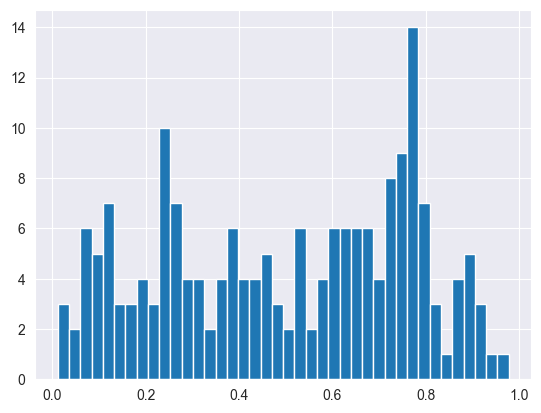

In [255]:
test.probability.hist(bins=40)

<Axes: xlabel='Date'>

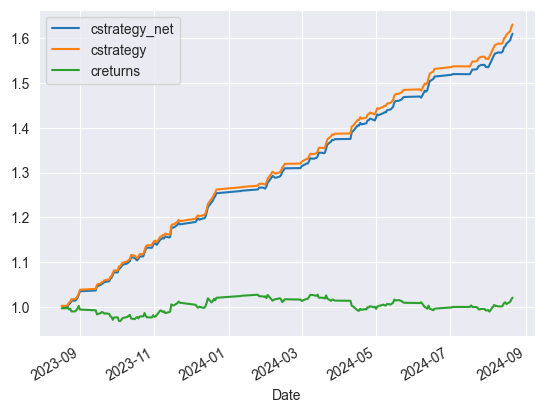

In [256]:
test[['cstrategy_net', 'cstrategy', 'creturns']].plot()

In [269]:
test[['strategy_net']].mean() * 252

strategy_net    0.644754
dtype: float64

In [257]:
test.creturns.corr(test.cstrategy)

0.4340164334587481

In [258]:
test['prediction_dir'] = np.select(
    [test['probability'] < 0.47, test['probability'] > 0.53],
    [0, 1],
    default=np.nan)

In [259]:
percentage_equal = (test['dir'] == test['prediction_dir']).mean() * 100
percentage_equal

79.14438502673798

In [260]:
print(train['dir'].value_counts())
print(test['dir'].value_counts())

dir
0.0    1783
1.0    1766
Name: count, dtype: int64
dir
0.0    94
1.0    93
Name: count, dtype: int64


C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Intercept 0.4166907625509284
Prediction_local [0.45999369]
Right: 0.23516043


C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\lime\lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

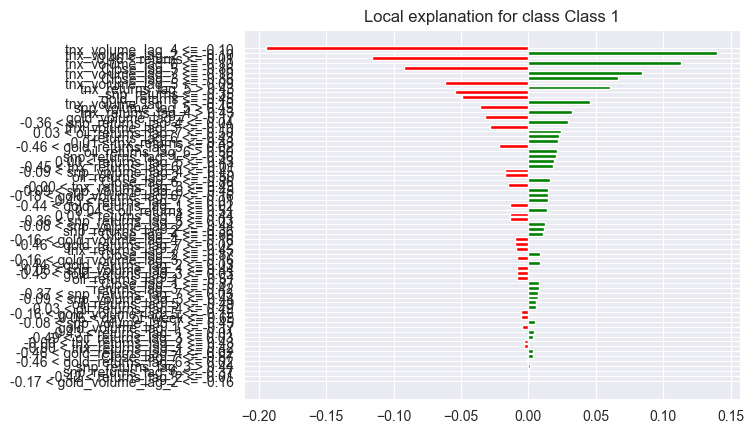

<Figure size 1000x3000 with 0 Axes>

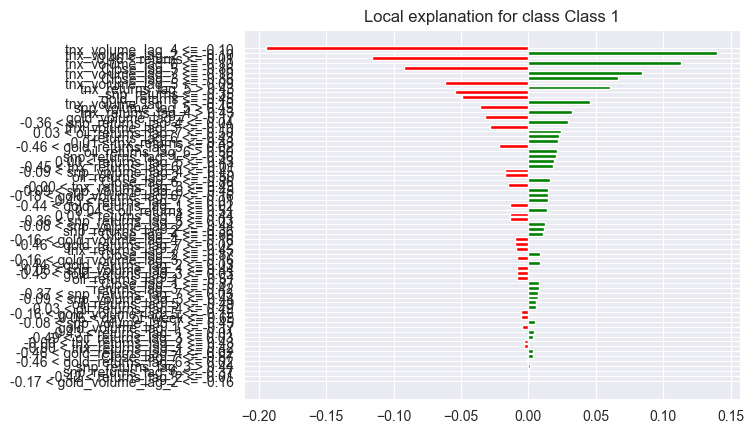

In [261]:
import lime
import lime.lime_tabular
import numpy as np

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(train_standardized[features]),
    mode='classification',
    feature_names=features,
    class_names=['Class 0', 'Class 1'],  # Assuming binary classification
    verbose=True,
    random_state=42
)

# Define a new predict function to return probabilities for both classes
def predict_fn(X):
    probs = model.predict(X)
    return np.hstack((1 - probs, probs))

# Pick a test instance to explain
i = 0  # Index of the test instance
exp = explainer.explain_instance(
    data_row=test_standardized[features].iloc[i],
    predict_fn=predict_fn,  # Modified predict function
    num_features=len(features)
)

plt.figure(figsize=(10, 30))  # Adjust the height (second value) as needed


# Show explanation (as text and visualization)
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()

In [262]:
model.save('daily_v6.keras')

In [263]:
import pickle

params = {'mu': mu, 'std': std}
pickle.dump(params, open('params_daily_V6.pkl', 'wb'))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


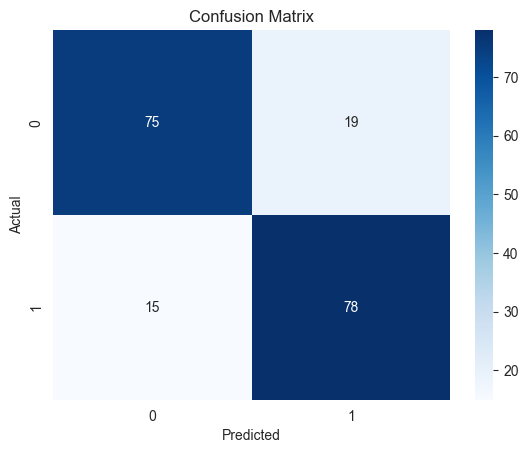

In [264]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = test['dir']  # Actual labels
y_pred_prob = model.predict(test_standardized[features])
y_pred = np.where(y_pred_prob >= 0.5, 1, 0)  # Convert probabilities to class predictions

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


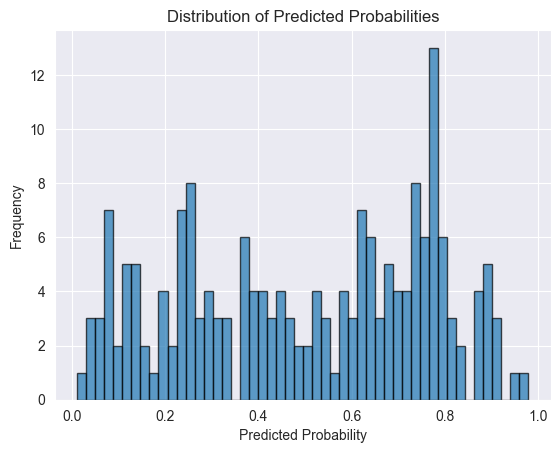

In [265]:
import matplotlib.pyplot as plt

# Predict probabilities
y_pred_prob = model.predict(test_standardized[features])

# Plot histogram of predicted probabilities
plt.hist(y_pred_prob, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()